In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
_ = camvid.create_segmented_y()

##### Note

Because of the skip connections between the down-sampling and up-sampling sides of the network, input image size must be divisible by 32 (2^5). This is because of the max pooling / transpose convolution layers on the down-sampling and up-sampling branch of the network respectively. There are 5 of these units each with 2x2 kernel size and stride 2. Thus, the input must be divisible by 2^5 to ensure the outputs along the down-sampling side of the net can concatenate with the up-sampling side.

In [4]:
# the size of the images in the dataset
target_size = (720, 960)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (512, 640)
# fine_crop = (480, 640)

# Coarse Tuning

train on random crops of size 224 x 224 (images are also random flipped about x and y axis)

In [5]:
camvid32 = camvid.CamVid('y_32', crop_size=coarse_crop)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


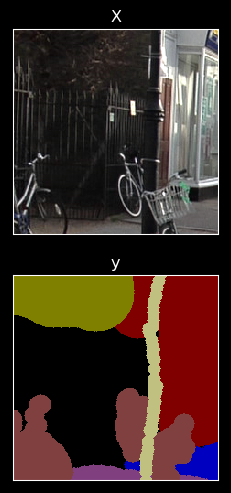

In [6]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [7]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-3,
)

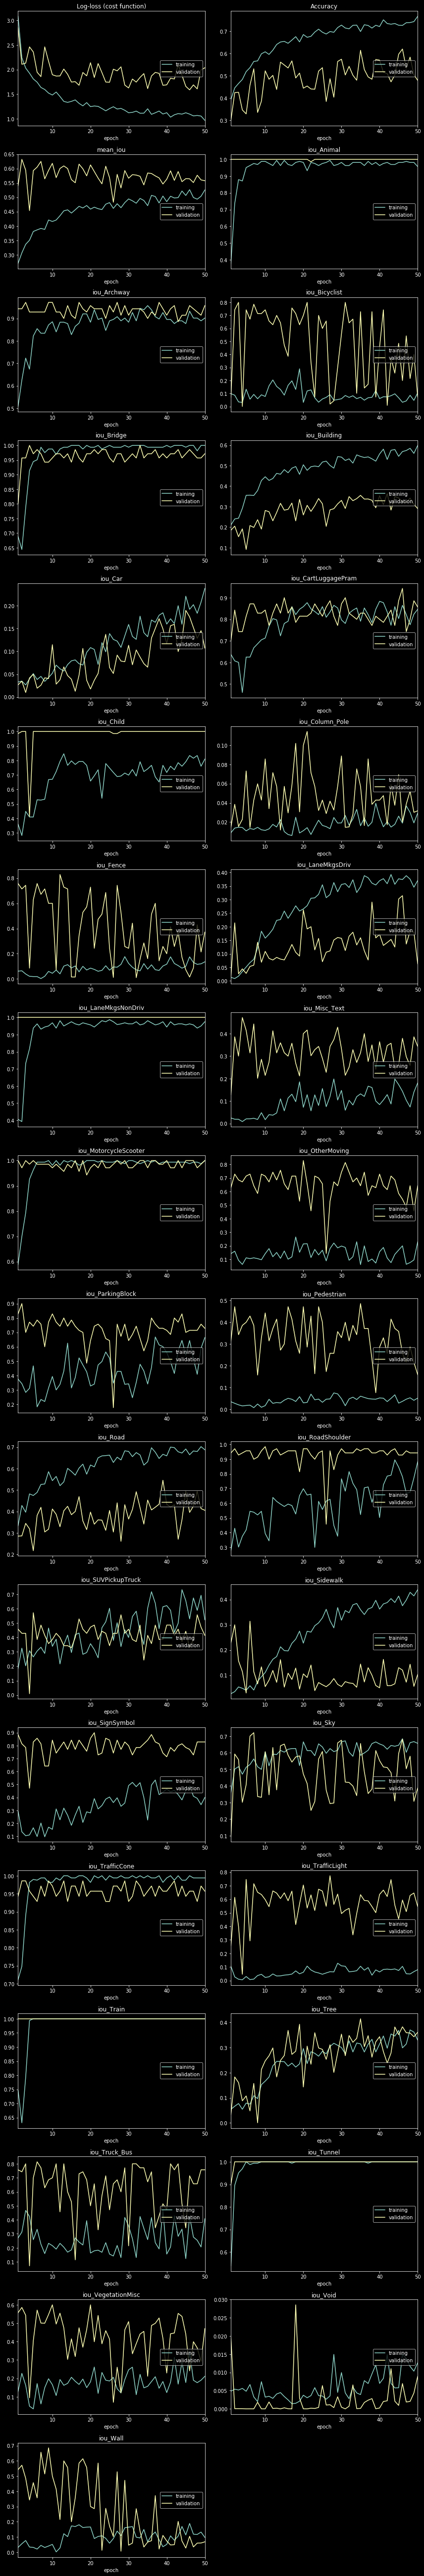

In [8]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [9]:
history_to_results(history)

train       val
acc                0.767157  0.479083
Animal             0.956967  1.000000
Archway            0.901639  0.957143
Bicyclist          0.106310  0.073183
Bridge             1.000000  0.971429
Building           0.598560  0.290657
Car                0.238017  0.107289
CartLuggagePram    0.846311  0.857143
Child              0.809426  1.000000
Column_Pole        0.029389  0.031733
Fence              0.135690  0.371671
LaneMkgsDriv       0.370381  0.062996
LaneMkgsNonDriv    0.975410  1.000000
Misc_Text          0.180866  0.343108
MotorcycleScooter  1.000000  1.000000
OtherMoving        0.228866  0.642857
ParkingBlock       0.663934  0.728571
Pedestrian         0.051366  0.158859
Road               0.687566  0.405590
RoadShoulder       0.883200  0.942857
SUVPickupTruck     0.522623  0.414286
Sidewalk           0.439194  0.103303
SignSymbol         0.399911  0.828571
Sky                0.656992  0.387980
TrafficCone        0.993852  0.957143
TrafficLight       0.080010  0.545971
Train              1.000000  1.000000
Tree               0.329803  0.360962
Truck_Bus          0.407624  0.757143
Tunnel             1.000000  1.000000
VegetationMisc     0.211337  0.470814
Void               0.012658  0.008942
Wall               0.096995  0.067819
loss               0.970544  2.036840
mean_iou           0.525466  0.557751

In [10]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss                   2.123048
acc                    0.463876
mean_iou               0.550875
iou_Animal             1.000000
iou_Archway            0.928571
iou_Bicyclist          0.026592
iou_Bridge             0.966667
iou_Building           0.315817
iou_Car                0.085157
iou_CartLuggagePram    0.819048
iou_Child              1.000000
iou_Column_Pole        0.038399
iou_Fence              0.300090
iou_LaneMkgsDriv       0.061348
iou_LaneMkgsNonDriv    1.000000
iou_Misc_Text          0.316650
iou_MotorcycleScooter  0.995238
iou_OtherMoving        0.604762
iou_ParkingBlock       0.723810
iou_Pedestrian         0.132397
iou_Road               0.402660
iou_RoadShoulder       0.947619
iou_SUVPickupTruck     0.452381
iou_Sidewalk           0.092619
iou_SignSymbol         0.771429
iou_Sky                0.336659
iou_TrafficCone        0.957143
iou_TrafficLight       0.657947
iou_Train              1.000000
iou_Tree               0.358709
iou_Truck_Bus          0.790476
iou_Tunnel             1.000000
iou_VegetationMisc     0.486783
iou_Void               0.008328
iou_Wall               0.050703

In [11]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

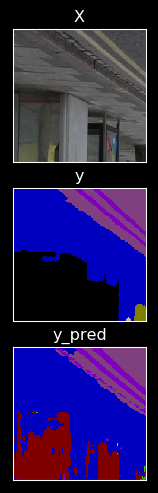

In [12]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

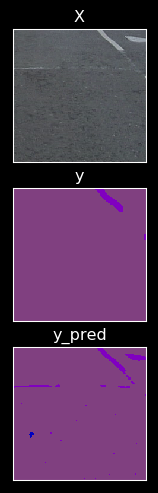

In [13]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

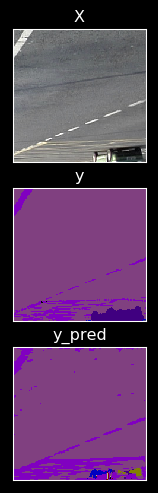

In [14]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [15]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

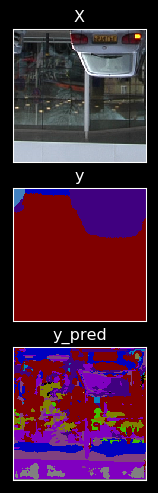

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

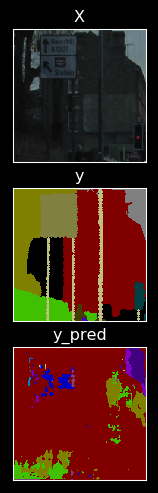

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

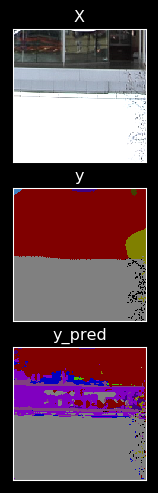

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [19]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid32-coarse.h5')

# Clear Session

remove the current model from memory.

In [20]:
from keras import backend as K
K.clear_session()

# Fine Tuning

Train on larger crops (because the full size image results in a OutOfMemory error on the P100). max queue size of the fit generator is also reduced (resulting in a slowdown) to accomodate these larger images.

In [21]:
camvid32 = camvid.CamVid('y_32', crop_size=fine_crop, batch_size=1)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


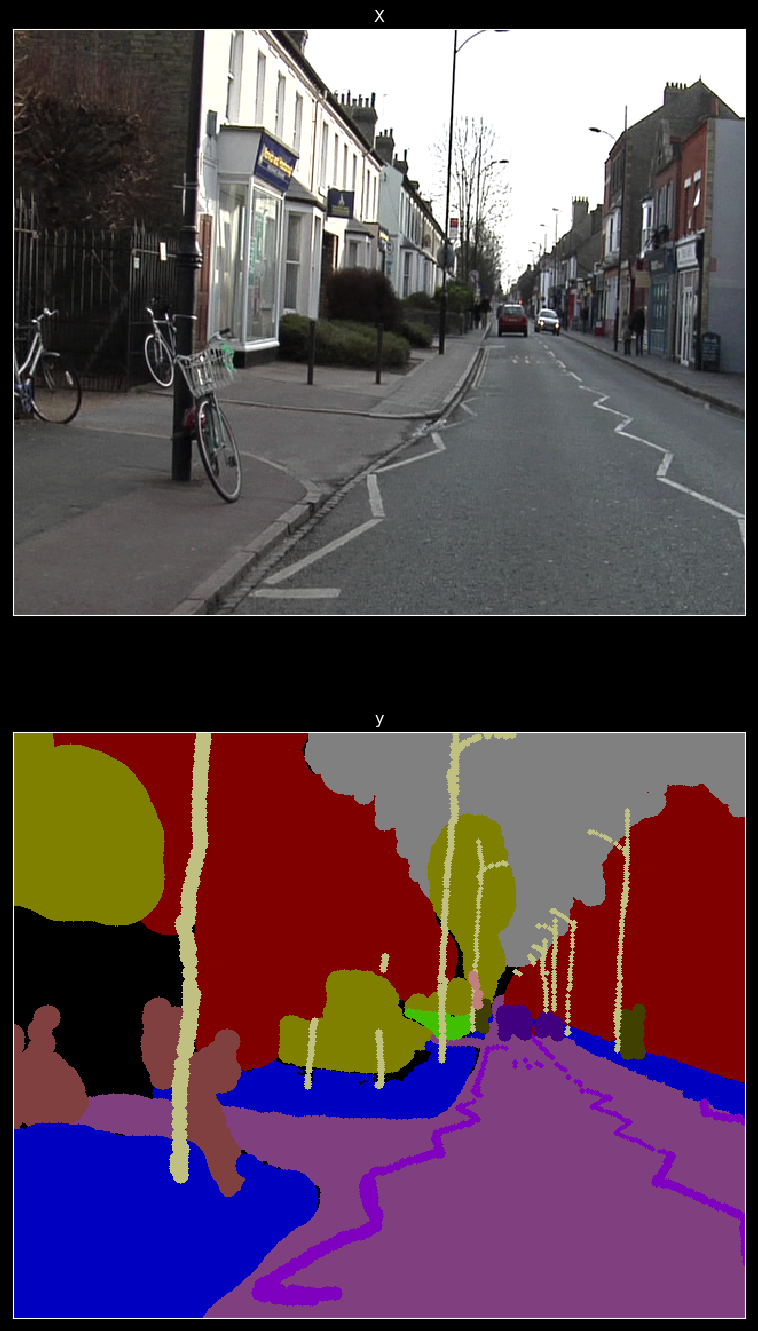

In [22]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [23]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid32-coarse.h5')

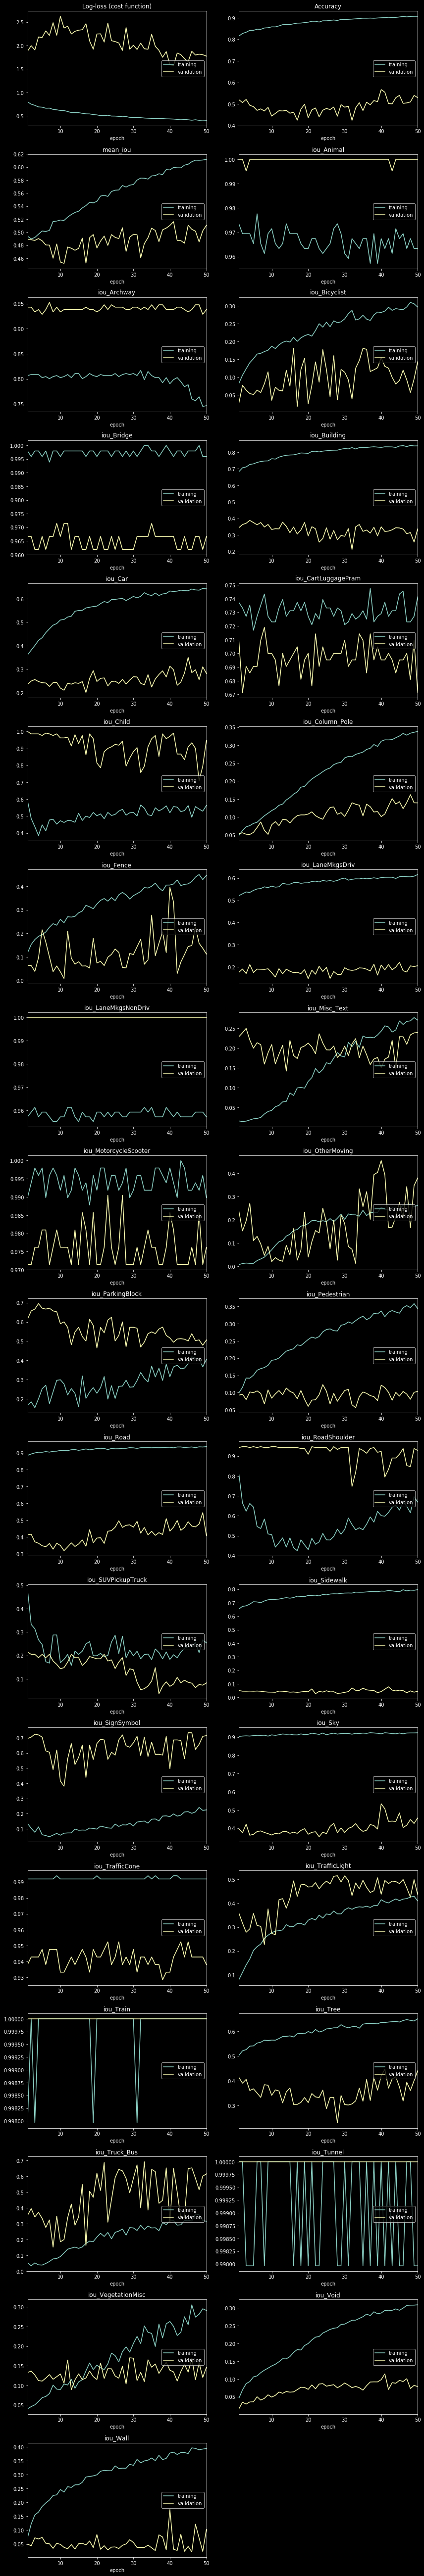

In [24]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [25]:
history_to_results(history)

train       val
acc                0.906725  0.529533
Animal             0.963340  1.000000
Archway            0.746355  0.938095
Bicyclist          0.296332  0.143717
Bridge             0.995927  0.966667
Building           0.838483  0.337560
Car                0.641638  0.281710
CartLuggagePram    0.741344  0.671429
Child              0.563166  0.947619
Column_Pole        0.337918  0.139207
Fence              0.445656  0.112681
LaneMkgsDriv       0.616226  0.205568
LaneMkgsNonDriv    0.957230  1.000000
Misc_Text          0.270621  0.239526
MotorcycleScooter  0.989817  0.976190
OtherMoving        0.261974  0.380744
ParkingBlock       0.404983  0.505803
Pedestrian         0.343283  0.103178
Road               0.937571  0.408390
RoadShoulder       0.668320  0.928571
SUVPickupTruck     0.253507  0.082602
Sidewalk           0.796467  0.044278
SignSymbol         0.224762  0.714308
Sky                0.923488  0.456468
TrafficCone        0.991853  0.938095
TrafficLight       0.409531  0.435769
Train              1.000000  1.000000
Tree               0.651237  0.440995
Truck_Bus          0.315681  0.614286
Tunnel             0.997963  1.000000
VegetationMisc     0.291203  0.146049
Void               0.308479  0.078610
Wall               0.393624  0.103073
loss               0.405743  1.775066
mean_iou           0.611812  0.510662

In [26]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

val
loss                   1.737203
acc                    0.536418
mean_iou               0.512697
iou_Animal             1.000000
iou_Archway            0.938095
iou_Bicyclist          0.153727
iou_Bridge             0.961905
iou_Building           0.334829
iou_Car                0.284164
iou_CartLuggagePram    0.690476
iou_Child              0.966667
iou_Column_Pole        0.143771
iou_Fence              0.101645
iou_LaneMkgsDriv       0.206406
iou_LaneMkgsNonDriv    1.000000
iou_Misc_Text          0.224854
iou_MotorcycleScooter  0.976190
iou_OtherMoving        0.360385
iou_ParkingBlock       0.520751
iou_Pedestrian         0.094218
iou_Road               0.416050
iou_RoadShoulder       0.923810
iou_SUVPickupTruck     0.069378
iou_Sidewalk           0.053551
iou_SignSymbol         0.700178
iou_Sky                0.477725
iou_TrafficCone        0.957143
iou_TrafficLight       0.457984
iou_Train              1.000000
iou_Tree               0.438044
iou_Truck_Bus          0.623810
iou_Tunnel             1.000000
iou_VegetationMisc     0.145174
iou_Void               0.077526
iou_Wall               0.107866

In [27]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

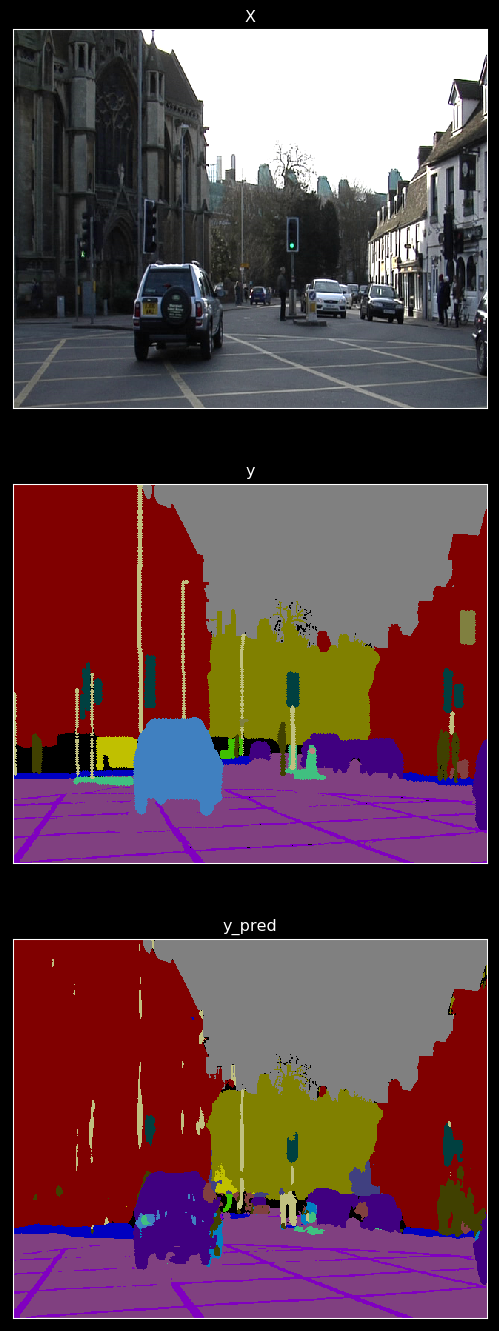

In [28]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [29]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

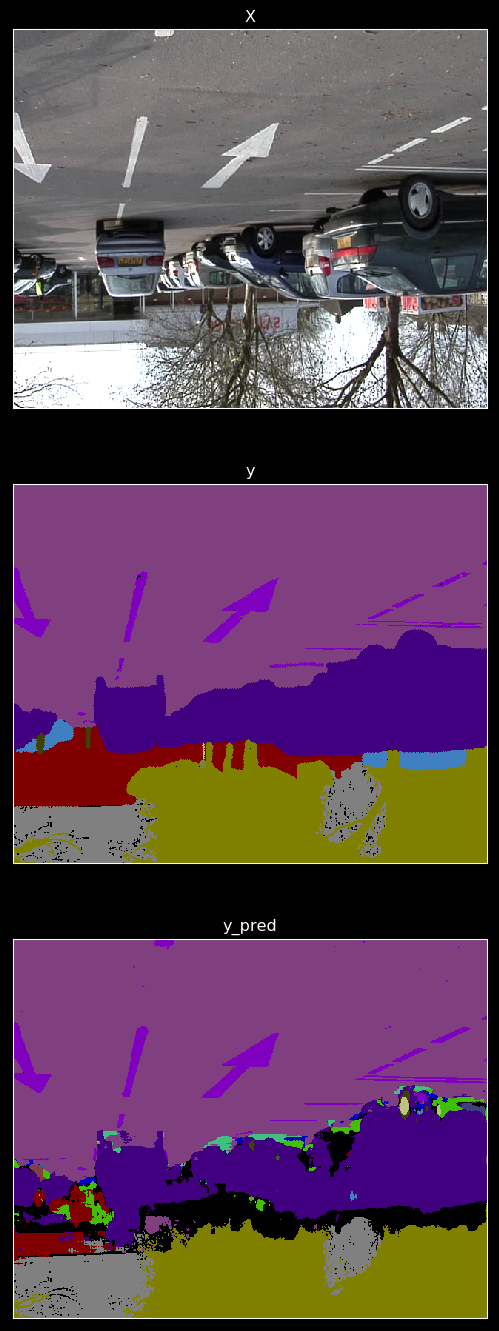

In [30]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [31]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid32-fine.h5')